<a href="https://colab.research.google.com/github/notrandomath/Omar-s-Entertainmentopedia/blob/main/Food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspired by / based on: [shakespeare generator](https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.ipynb)

# Import Dependencies

In [1]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import ast

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)

Python version: 3.10.12
Tensorflow version: 2.14.0


# Import Dataset


change project folder location to google drive (source: https://robertbrucecarter.com/writing/2020/06/setting-your-working-directory-to-google-drive-in-a-colab-notebook/)

In [2]:
# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/MyDrive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/Food/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

create_and_set_working_directory(project_folder)

based on [stack overflow](https://stackoverflow.com/a/53282688)

In [3]:
df=pd.read_csv('food_recipes/RAW_recipes.csv')
df = df.head(1024)
print(df)

                                            name      id  minutes  \
0     arriba   baked winter squash mexican style  137739       55   
1               a bit different  breakfast pizza   31490       30   
2                      all in the kitchen  chili  112140      130   
3                             alouette  potatoes   59389       45   
4             amish  tomato ketchup  for canning   44061      190   
...                                          ...     ...      ...   
1019                         1949  spanish  rice  394049       60   
1020                    1949 country style steak  221166       20   
1021                             1950 s brownies  254267       42   
1022                    1950 s hamburger goulash  109232       50   
1023                             1950 s meatloaf  275691       85   

      contributor_id   submitted  \
0              47892  2005-09-16   
1              26278  2002-06-17   
2             196586  2005-02-25   
3              68585  2003-

# Analyze Dataset

In [4]:
def convert_to_numbered_list(string_representation):
    lst = ast.literal_eval(string_representation)
    formatted_list = [f"{i + 1}. {item}" for i, item in enumerate(lst)]
    return "\n".join(formatted_list) + '\n'
df['steps'] = df['steps'].apply(lambda x: convert_to_numbered_list(x))

all_steps_text = ''.join(df['steps'])
# gets length of all the steps in all recipes
print(len(all_steps_text))
# prints first steps
print(all_steps_text[:250])
# prints the unique characters in the file
vocab = sorted(set(all_steps_text.split()))
print(f'{len(vocab)} unique words')
print(f'vocab: {vocab}')

561898
1. make a choice and proceed with recipe
2. depending on size of squash , cut into half or fourths
3. remove seeds
4. for spicy squash , drizzle olive oil or melted butter over each cut squash piece
5. season with mexican seasoning mix ii
6. for swee
4593 unique words
vocab: ['!', '"', '"al', '"basic"', '"basket"', '"batter"', '"beginner"', '"bun"', '"buttermilk"', '"caramalized"', '"cheese"', '"chicken"', '"chill"', '"cinnamon', '"combine', '"cooking"', '"crusty"', '"dances"', '"dress', '"dry"', '"dust"', '"exactly', '"eyeballing"', '"float"', '"flower', '"flower"', '"fudgy"', '"give"', '"high"', '"hold"in', '"ice', '"jiggly"', '"ketchup"', '"lettuce"', '"light"', '"little', '"low"', '"mash"', '"mc', '"milk"', '"mustard"', '"naked"', '"noodles"', '"one-dish"', '"paint"', '"petals"', '"pounding"', '"rest', '"rough"', '"sauce', '"sauce"', '"scoop"', '"shirataki"', '"shriveled"', '"sink"', '"slushy"', '"soupy"', '"special', '"squeaking"', '"start"', '"the', '"thicken"', '"v"', '"w

# Process Dataset

## Vectorize the Text
Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [5]:
# Map characters to their indices in vocabulary.
word2index = {word: index for index, word in enumerate(vocab)}

print('{')
for word, _ in zip(word2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(word), word2index[word]))
print('  ...\n}')

# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

# Convert chars in text to indices.
df['steps_int'] = df['steps'].apply(lambda x: [word2index[word] for word in x.split()])
text_as_int = df['steps_int'].explode().reset_index(drop=True).tolist()

print(f'text_as_int length: {len(text_as_int)}')
print(f'({all_steps_text[:15]})->({text_as_int[:15]})')

{
  '!' :   0,
  '"' :   1,
  '"al':   2,
  '"basic"':   3,
  '"basket"':   4,
  '"batter"':   5,
  '"beginner"':   6,
  '"bun"':   7,
  '"buttermilk"':   8,
  '"caramalized"':   9,
  '"cheese"':  10,
  '"chicken"':  11,
  '"chill"':  12,
  '"cinnamon':  13,
  '"combine':  14,
  '"cooking"':  15,
  '"crusty"':  16,
  '"dances"':  17,
  '"dress':  18,
  '"dry"':  19,
  ...
}
['!' '"' '"al' ... '~' '~30' '~tasty~']
text_as_int length: 111554
(1. make a choic)->([119, 2517, 484, 1088, 590, 3220, 4510, 3322, 231, 1435, 2861, 3691, 2837, 3863, 88])


# Create training sequences

In [6]:
# # Convert the pandas DataFrame to a tf.data.Dataset
sub_text_as_int = df['steps_int'].explode().reset_index(drop=True).tolist()
# steps_list = sub_df['steps_int'].tolist()

# # Find the maximum length in the list
# max_length = max(len(x) for x in steps_list)

# # Pad the lists to the maximum length
# padded_steps_list = [x + [0] * (max_length - len(x)) for x in steps_list]

# Create a TensorFlow dataset from the padded list
# chunk_size = 32
dataset = tf.data.Dataset.from_tensor_slices(sub_text_as_int)

for char in dataset.take(5):
    print(index2char[char.numpy()])

# make sequences
sequence_length = 100
dataset = dataset.batch(sequence_length+1, drop_remainder=True)

for item in dataset.take(5):
  print(' '.join(index2char[item.numpy()]))

1.
make
a
choice
and
1. make a choice and proceed with recipe 2. depending on size of squash , cut into half or fourths 3. remove seeds 4. for spicy squash , drizzle olive oil or melted butter over each cut squash piece 5. season with mexican seasoning mix ii 6. for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece 7. season with sweet mexican spice mix 8. bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin 9. be careful
not to burn the squash especially if you opt to use sugar or butter 10. if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking 11. if desired , season with salt 1. preheat oven to 425 degrees f 2. press dough into the bottom and sides of a 12 inch pizza pan 3. bake for 5 minutes until set but not browned 4. cut sausage into small pieces 5. whisk eggs and milk in a bowl until frothy 6. spoon sausage over 

In [7]:
def split_input_target(chunk):
    input_text = chunk[:-1] # input_text = chunk[:, :-1]
    target_text = chunk[1:] # target_text = chunk[:, 1:]
    return input_text, target_text

    # return input_text, target_text

dataset = dataset.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

for input_example, target_example in dataset.take(1):
    print(f'Input sequence size: {len(input_example.numpy())}')
    print(f'Input sequence size: {len(target_example.numpy())}')
    print()
    print('Input: ' + ''.join(str(index2char[i]) for i in input_example.numpy()))
    print('Target: ' + ''.join(str(index2char[i]) for i in target_example.numpy()))

for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print(f'  input: {input_idx} ({index2char[input_idx]})')
    print(f'  expected output: {target_idx} ({index2char[target_idx]})')

dataset size: 1104
Input sequence size: 100
Input sequence size: 100

Input: 1.makeachoiceandproceedwithrecipe2.dependingonsizeofsquash,cutintohalforfourths3.removeseeds4.forspicysquash,drizzleoliveoilormeltedbutterovereachcutsquashpiece5.seasonwithmexicanseasoningmixii6.forsweetsquash,drizzlemeltedhoney,butter,gratedpiloncilloovereachcutsquashpiece7.seasonwithsweetmexicanspicemix8.bakeat350degrees,againdependingonsize,for40minutesuptoanhour,untilaforkcaneasilypiercetheskin9.be
Target: makeachoiceandproceedwithrecipe2.dependingonsizeofsquash,cutintohalforfourths3.removeseeds4.forspicysquash,drizzleoliveoilormeltedbutterovereachcutsquashpiece5.seasonwithmexicanseasoningmixii6.forsweetsquash,drizzlemeltedhoney,butter,gratedpiloncilloovereachcutsquashpiece7.seasonwithsweetmexicanspicemix8.bakeat350degrees,againdependingonsize,for40minutesuptoanhour,untilaforkcaneasilypiercetheskin9.becareful
Step  0
  input: 119 (1.)
  expected output: 2517 (make)
Step  1
  input: 2517 (make)
  expected o

# Build the Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           1175808   
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 4593)          4707825   
                                                                 
Total params: 11130609 (42.46 MB)
Trainable params: 11130609 (42.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


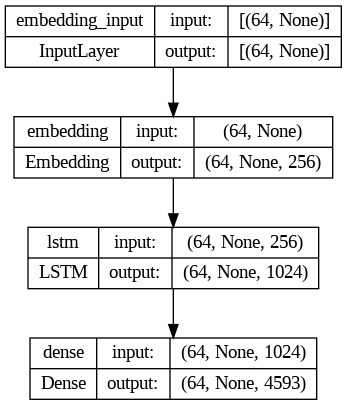

In [8]:
# Define the batch size
batch_size = 64

# Batch the dataset
dataset = dataset.batch(batch_size, drop_remainder=True)

# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

# *Test* the Model

In [9]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 4593) # (batch_size, sequence_length, vocab_size)


In [10]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 1.0486529e-03 -7.6355645e-06  8.0185907e-04 ...  2.6644728e-04
 -2.5425204e-03  1.0828179e-03], shape=(4593,), dtype=float32)


# Train the model

In [11]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

Prediction shape:  (64, 100, 4593)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       8.432334


# Configure Checkpoints

In [12]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Execute the training

In [ ]:
for input_data, labels in dataset.take(1):
    print("Input data shape:", input_data.shape)
    print("Labels shape:", labels.shape)

EPOCHS=40

history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Input data shape: (64, 100)
Labels shape: (64, 100)
Epoch 1/40
17/17 [==============================] - 214s 12s/step - loss: 6.8292
Epoch 2/40
17/17 [==============================] - 210s 12s/step - loss: 6.1623
Epoch 3/40
17/17 [==============================] - 205s 12s/step - loss: 6.0963
Epoch 4/40
17/17 [==============================] - 207s 12s/step - loss: 6.0251
Epoch 5/40
17/17 [==============================] - 203s 12s/step - loss: 5.8857
Epoch 6/40
17/17 [==============================] - 208s 12s/step - loss: 5.7034
Epoch 7/40
17/17 [==============================] - 202s 12s/step - loss: 5.5139
Epoch 8/40
17/17 [==============================] - 201s 12s/step - loss: 5.3441
Epoch 9/40
17/17 [==============================] - 206s 12s/step - loss: 5.1965
Epoch 10/40
17/17 [==============================] - 200s 12s/step - loss: 5.0652
Epoch 11/40
17/17 [==============================] - 202s 12s/step - loss: 4.9345
Epoch 12/40
17/17 [==============================] - 20

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()
render_training_history(history)

# Generate text

In [13]:
checkpoint_dir = 'tmp/checkpoints'

tf.train.latest_checkpoint(checkpoint_dir)

simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            1175808   
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 4593)           4707825   
                                                                 
Total params: 11130609 (42.46 MB)
Trainable params: 11130609 (42.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_index = [word2index[start_string]]
    input_indices = tf.expand_dims(input_index, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        if "." in index2char[predicted_id]:
          text_generated.append('\n')
        text_generated.append(index2char[predicted_id])


    return (start_string + ' '.join(text_generated))

# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"1."))

1.may rimmed sure a pinch of center corner in a half of full cup of flour 
 4. bake about 30 minutes , stirring and serve with paper resembles a toothpick sheet 
 3. option:mince sure 
 6. set aside , combine meat and spinach 
 1. combine margarine and apple juice a dinner 8 comes out clean 
 1. measure the dry black tomatoes butter butter 
 10. add the glass flour , salt , baking soda and pudding milk the cooking 
 2. stir together with oil 
 3. beat the chicken nutty & mix on order side 
 2. remove from heat , loosely and cornstarch 
 3. layer until tender has mixed 
 6. add bisquick & apple 
 4. allow 30 seconds 
 10. allow to simmer for 10 minutes 
 8. chop an blended 
 1. heat cream on medium speed 
 4. set aside 
 5. stir until blended 
 2. pour in wire filets 
 4. over burner or bowl and mix 
 2. add splenda , and extracts with baking towels , let in a separate bowl commonly 
 11. prepare bbq whip the shallots into last bowl , grahm spaghetti and dough to maintain pasta 
 2. in 

In [15]:
model_name = 'text_generation_shakespeare_rnn.h5'
model.save(model_name, save_format='h5')
!cp -r './text_generation_shakespeare_rnn.h5' /content/drive/MyDrive/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
